In [47]:
import os
import psignifit as ps
import glob
# import pickle as pkl
import dill as pkl
import numpy as np
import pylab as pl
import seaborn as sns
import scipy.stats as spstats
import pandas as pd
import importlib

import scipy as sp
import itertools

# /n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/psignifit  

In [3]:
%matplotlib notebook

In [4]:
responsive_test='ROC'
responsive_thr=10. if responsive_test=='nstds' else 0.05
experiment='blobs'

traceid = 'traces001'
fov_type = 'zoom2p0x'
state = 'awake'
rootdir = '/n/coxfs01/2p-data'
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
stats_dir = os.path.join(aggregate_dir, 'data-stats')

In [5]:
src_data_dir = os.path.join(aggregate_dir, 'data_stats', 'tmp_data')
dfns = glob.glob(os.path.join(src_data_dir, '*.pkl'))
dfns

['/n/coxfs01/julianarhee/aggregate-visual-areas/data_stats/tmp_data/neuraldata_traces001_corrected_ROC-thr-0.05_plushalf_noRFs.pkl',
 '/n/coxfs01/julianarhee/aggregate-visual-areas/data_stats/tmp_data/results.pkl',
 '/n/coxfs01/julianarhee/aggregate-visual-areas/data_stats/tmp_data/R.pkl']

In [6]:
src_datafile = os.path.join(src_data_dir, dfns[0])
with open(src_datafile, 'rb') as f:
    D = pkl.load(f, encoding='latin1')
D.keys()

dict_keys(['SDF', 'DATA', 'sdata', 'selective_df'])

In [7]:
DATA = D['DATA']
sdata = D['sdata']
SDF = D['SDF']
selective_df = D['selective_df']
DATA.head()

,datakey,config,trial,visual_area,cell,response,baseline
0,20190511_JC083_fov1,config047,1,V1,1,496.384479,486.518475
1,20190511_JC083_fov1,config021,2,V1,1,488.806161,482.074471
2,20190511_JC083_fov1,config031,3,V1,1,495.635289,488.475950
3,20190511_JC083_fov1,config032,4,V1,1,492.005017,488.053510
4,20190511_JC083_fov1,config014,5,V1,1,489.278178,496.740024


# Calculate AUC as performance

In [10]:


# def get_morph_levels(midp=53, levels=[-1, 0, 14, 27, 40, 53, 66, 79, 92, 106]):

#     a_morphs = np.array(sorted([m for m in levels if m<midp and m!=-1]))[::-1]
#     b_morphs = np.array(sorted([m for m in levels if m>midp and m!=-1]))

#     d1 = dict((k, list(a_morphs).index(k)+1) for k in a_morphs)
#     d2 = dict((k, list(b_morphs).index(k)+1) for k in b_morphs)
#     morph_lut = d1.copy()
#     morph_lut.update(d2)
#     morph_lut.update({midp: 0, -1: -1})

#     return morph_lut, a_morphs, b_morphs


In [66]:
# def split_sample_half(g):
#     nt = int(np.floor(len(g['trial'].unique())/2.))
#     d1 = g[['trial', 'response']].sample(n=nt, replace=False)
#     d2 = g[~g['trial'].isin(d1['trial'])].sample(n=nt)[['trial', 'response']]

#     #pB = len(np.where(d1['response'].values>d2['response'].values)[0])/float(len(d1))
#     return d1, d2


# def get_hits_and_fas(resp_stim, resp_bas, n_crit=50):
    
#     # Get N conditions
#     n_conditions = len(resp_stim) #curr_cfg_ixs)
 
#     # Set criterion (range between min/max response)
#     min_val = min(list(itertools.chain(*resp_stim))) #resp_stim.min()
#     max_val = max(list(itertools.chain(*resp_stim))) #[r.max() for r in resp_stim]) #resp_stim.max() 
#     crit_vals = np.linspace(min_val, max_val, n_crit)
   
#     # For each crit level, calculate p > crit (out of N trials)   
#     p_hits = np.array([[sum(rs > crit)/float(len(rs)) for crit in crit_vals] for rs in resp_stim])
#     p_fas = np.array([[sum(rs > crit)/float(len(rs)) for crit in crit_vals] for rs in resp_bas])

#     return p_hits, p_fas, crit_vals


# def split_AB_morphstep(rdf, param='morphstep', Eff=None, include_ref=True, class_a=0, class_b=106):
#     '''
#     rdf_sz = responses at each morph level (including diff sizes)
#     Eff = effective class overall (0 or 106)
#     resp_B, corresonds to response distn of Effective stimulus
#     resp_A, corresponds to response distn if Ineffective stimulus
#     '''
#     # Split responses into A and B distns at each morph step
#     Eff_obj = 'A' if Eff==class_a else 'B'
#     Ineff_obj = 'B' if Eff_obj=='A' else 'B'
#     resp_A=[]; resp_B=[]; resp_cfgs=[]; resp_counts=[];
    
#     if include_ref:
#        # Split responded to morphstep=0 in half:
#         split_halves = [split_sample_half(g) for c, g in rdf[rdf.object=='M'].groupby(['size', param])]
#         resp_A_REF = [t[0]['response'].values for t in split_halves]
#         resp_B_REF = [t[1]['response'].values for t in split_halves]
#         resp_cfgs_REF = [c for c, g in rdf[rdf.object=='M'].groupby(['size', param])]
#         resp_counts_REF = [g.shape[0] for c, g in rdf[rdf.object=='M'].groupby(['size', param])]
        
#         # Add to resp
#         resp_A.extend(resp_A_REF)
#         resp_B.extend(resp_B_REF)
#         resp_counts.extend(resp_counts_REF)
#         resp_cfgs.extend(resp_cfgs_REF)

#     # Get all the other responses
#     resp_A_ = [g['response'].values for c, g in rdf[rdf.object==Ineff_obj].groupby(['size', param])]
#     resp_B_ = [g['response'].values for c, g in rdf[rdf.object==Eff_obj].groupby(['size', param])]
    
#     # Corresponding configs
#     resp_cfgs1_ = [c for c, g in rdf[rdf.object==Ineff_obj].groupby(['size', param])]
#     resp_cfgs2_ = [c for c, g in rdf[rdf.object==Eff_obj].groupby(['size', param])]
#     assert resp_cfgs1_==resp_cfgs2_, \
#         "ERR: morph levels and sizes don't match for object A and B"
#     # Corresponding counts
#     resp_counts1_ = [g.shape[0] for c, g in rdf[rdf.object==Ineff_obj].groupby(['size', param])]
#     resp_counts2_ = [g.shape[0] for c, g in rdf[rdf.object==Eff_obj].groupby(['size', param])]
#     assert resp_counts1_==resp_counts2_, \
#         "ERR: Trial counts don't match for object A and B"
    
#     resp_cfgs.extend(resp_cfgs1_)
#     resp_counts.extend(resp_counts1_)
    
#     return resp_A, resp_B, resp_cfgs, resp_counts


# def split_AB_morphlevel(rdf, param='morphlevel', Eff=None, include_ref=True, class_a=0, class_b=106):
#     '''
#     rdf_sz = responses at each morph level (~ including diff sizes)
#     Eff = effective class overall (0 or 106)
#     resp_B, corresonds to response distn of Effective stimulus
#     resp_A, corresponds to response distn if Ineffective stimulus
#     '''
#     Ineff = class_b if Eff==class_a else class_a
#     resp_A=[]; resp_B=[]; resp_cfgs=[]; resp_counts=[];

#     # Responses to Everythign that's not "Ineffective" stimuli
#     resp_B = [g['response'].values for c, g in rdf[rdf['morphlevel']!=Ineff].groupby(['size', param])]
#     resp_cfgs = [c for c, g in rdf[rdf['morphlevel']!=Ineff].groupby(['size', param])]
#     resp_counts = [g.shape[0] for c, g in rdf[rdf['morphlevel']!=Ineff].groupby(['size', param])]

#     # Responses to "Ineffective" (baseline distN)
#     if include_ref:
#         # Split responses to Eff in half
#         split_halves = [split_sample_half(g) for c, g in rdf[rdf['morphlevel']==Ineff].groupby(['size', param])]
#         resp_A = [t[0]['response'].values for t in split_halves]
#         resp_A_REF = [t[1]['response'].values for t in split_halves]
#         resp_cfgs_REF = [c for c, g in rdf[rdf['morphlevel']==Ineff].groupby(['size', param])]
#         resp_counts_REF = [g.shape[0] for c, g in rdf[rdf['morphlevel']==Ineff].groupby(['size', param])]

#         # Add to list of comparison DistNs
#         resp_B.extend(resp_A_REF)
#         resp_cfgs.extend(resp_cfgs_REF)
#         resp_counts.extend(resp_counts_REF)
#     else:
#         resp_A = [g['response'].values for c, g in rdf[rdf['morphlevel']==Ineff].groupby(['size', param])]
        

#     return resp_A, resp_B, resp_cfgs, resp_counts

            
# def split_signal_distns(rdf, param='morphlevel', n_crit=50, include_ref=True, Eff=None,
#                        class_a=0, class_b=106):
#     '''
#     param=='morphstep':
#         Compare objectA vs B distributions at each morph step 
#         Levels: 0=53/53, 1=40/66, 2=27/79, 3=4=14/92, 4=0/106
#         Split trials into halves to calculate "chance" distN (evens/odds)
#     param=='morph_ix' or 'morphlevel'
#         Compare Ineffective distN against Effective distNs.
#         Eff = prefered A or B, Ineff, the other object.
#         Split trials into halfs for Ineff distN (evens/odds)
        
#     '''
#     Ineff=class_b if Eff==class_a else class_a
#     if param=='morphstep':
#         resp_A, resp_B, resp_cfgs, resp_counts = split_AB_morphstep(rdf, param=param, Eff=Eff, include_ref=include_ref)
        
#     else:
#         resp_A, resp_B, resp_cfgs, resp_counts = split_AB_morphlevel(rdf, param=param, 
#                                                                     Eff=Eff, include_ref=include_ref)

#     p_hits, p_fas, crit_vals = get_hits_and_fas(resp_B, resp_A, n_crit=n_crit)
    
#     return p_hits, p_fas, resp_cfgs, resp_counts
    
    
# def calculate_auc(p_hits, p_fas, resp_cfgs1, reverse_eff=False, Eff=None):
#     if p_fas.shape[0] < p_hits.shape[0]:
#         altconds = list(np.unique([c[0] for c in resp_cfgs1]))
#         true_auc = [-np.trapz(p_hits[ci, :], x=p_fas[altconds.index(sz), :]) \
#                             for ci, (sz, mp) in enumerate(resp_cfgs1)]
#     else:
#         true_auc = [-np.trapz(p_hits[ci, :], x=p_fas[ci, :]) for ci in np.arange(0, len(resp_cfgs1))]
        
#     aucs = pd.DataFrame({'AUC': true_auc, 
#                           param: [r[1] for r in resp_cfgs1], 
#                          'size': [r[0] for r in resp_cfgs1]}) 
#     if reverse_eff and Eff==0:
#         # flip
#         for sz, a in aucs.groupby(['size']):
#             aucs.loc[a.index, 'AUC'] = a['AUC'].values[::-1]
        
#     return aucs


# def get_auc_AB(rdf, param='morphlevel', n_crit=50, include_ref=True, reverse_eff=False,
#                   class_a=0, class_b=106, return_probs=False):
#     '''
#     Calculate AUCs for A vs. B at each size. 
#     Note:  rdf must contain columns 'morphstep' and 'size' (morphstep LUT from: get_morph_levels())

#     include_ref: include morphlevel=0 (or morph_ixx) by splitting into half.
#     Compare p_hit (morph=0) to p_fa (morph=106), calculate AUC.
#     '''
#     # Get Eff/Ineff
#     means = rdf[rdf.morphlevel.isin([class_a, class_b])].groupby(['object']).mean()
#     Eff = class_a if means['response']['A'] > means['response']['B'] else class_b

#     p_hits, p_fas, resp_cfgs, counts = split_signal_distns(rdf, param=param, n_crit=n_crit, 
#                                                         include_ref=include_ref, Eff=Eff)
        
#     aucs =  calculate_auc(p_hits, p_fas, resp_cfgs, reverse_eff=reverse_eff, Eff=Eff)
#     aucs['n_trials'] = counts
#     aucs['Eff'] = Eff
    
#     if return_probs:
#         return aucs, p_hits, p_fas, resp_cfgs
#     else:
#         return aucs.sort_values(by=['size', 'morphlevel'])

# def plot_auc_for_cell(rdf, param='morphlevel', class_a=0, class_b=106, n_crit=50, include_ref=True, cmap='RdBu'):
    
#     means = rdf[rdf.morphlevel.isin([class_a, class_b])].groupby(['object']).mean()
#     print(means)
#     # Get Eff/Ineff
#     Eff = class_a if means['response']['A'] > means['response']['B'] else class_b

#     # Calculate p_hits/p_fas for plot
#     p_hits, p_fas, resp_cfgs1 = split_signal_distns(rdf, param=param, n_crit=n_crit, 
#                                                     include_ref=include_ref, Eff=Eff)
#     print(p_hits.shape, p_fas.shape, len(resp_cfgs1))
#     aucs = calculate_auc(p_hits, p_fas, resp_cfgs1, reverse_eff=False, Eff=Eff)

#     # Plot----
#     mdiffs = sorted(aucs[param].unique())
#     mdiff_colors = sns.color_palette(cmap, n_colors=len(mdiffs))
#     colors = dict((k, v) for k, v in zip(mdiffs, mdiff_colors))

#     fig, axn = pl.subplots(1, len(sizes), figsize=(8,3))    
#     for ci, (sz, mp) in enumerate(resp_cfgs1):
#         si = sizes.index(sz)
#         ax=axn[si]
#         if param=='morphstep':
#             ax.plot(p_fas[ci, :], p_hits[ci, :], color=colors[mp], label=mp)
#         else:
#             ax.plot(p_fas[si, :], p_hits[ci, :], color=colors[mp], label=mp)
#         ax.set_title(sz)
#         ax.set_aspect('equal')
#         ax.plot([0, 1], [0, 1], linestyle=':', color='k', lw=1)
#     ax.legend(bbox_to_anchor=(1, 1.2), loc='lower right', title=param, ncol=5)
#     pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, hspace=0.5, wspace=0.5, top=0.7)
#     return fig

In [56]:
aucs.head()

,AUC,morphlevel,size,n_trials,Eff
0,0.548889,0,10.0,30,0
1,0.480000,14,10.0,30,0
2,0.452222,27,10.0,30,0
3,0.455556,40,10.0,30,0
4,0.537778,53,10.0,30,0


In [16]:
# def data_matrix_from_auc(auc_, param='morphlevel', normalize=False):
#     auc_['n_chooseB'] = auc_['AUC'] * auc_['n_trials']
#     auc_['n_chooseB'] = np.ceil(auc_['n_chooseB']) #.astype(int)
    
#     if normalize:
#         maxv = float(auc_[param].max())
#         auc_[param] = auc_[param]/maxv
    
#     sort_cols = [param]
#     if 'size' in auc_.columns:
#         sort_cols.append('size')
        
#     data = auc_.sort_values(by=sort_cols)[[param, 'n_chooseB', 'n_trials']].values

#     return data

In [90]:
# def aggregate_AUC(DATA, SDF, param='morphlevel', midp=53, reverse_eff=False,
#                   selective_only=False, selective_df=None, create_new=False):
#     tmp_res = '/n/coxfs01/julianarhee/aggregate-visual-areas/data_stats/tmp_data/AUC.pkl'
#     if not create_new:
#         try:
#             with open(tmp_res, 'rb') as f:
#                 AUC = pkl.load(f, encoding='latin1')
#                 print(AUC.head())
#         except Exception as e:
#             create_new = True

#     if create_new:
#         print("... creating new AUC dfs")
#         AUC = create_auc_dataframe(DATA, SDF, param=param, midp=midp)
#         with open(tmp_res, 'wb') as f:
#             pkl.dump(AUC, f, protocol=2)

#     if selective_only:
#         print("... getting selective only")
#         assert selective_df is not None, \
#             "[ERR]. Requested SELECTIVE ONLY. Must provide selective_df. Aborting."
        
#         mAUC = AUC.copy()
#         AUC = pd.concat([mAUC[(mAUC.visual_area==va) & (mAUC.datakey==dk) & (mAUC['cell'].isin(sg['cell'].unique()))] \
#                 for (va, dk), sg in selective_df.groupby(['visual_area', 'datakey'])])
        
#     if reverse_eff:
#         print("... reversing")
#         mAUC = AUC.copy()
#         to_reverse = mAUC[mAUC['Eff']==0].copy()
#         for (va, dk, c, sz), auc_ in to_reverse.groupby(['visual_area', 'datakey', 'cell', 'size']):
#             # flip
#             AUC.loc[auc_.index, 'AUC'] = auc_['AUC'].values[::-1]

#     return AUC


# def create_auc_dataframe(DATA, SDF, param='morphlevel', midp=53):
#     '''
#     DATA: neuraldata dataframe (all data)
#     SDF: dict of stimconfig dfs
#     reverse_eff:  set False to allow negative sigmoid
#     selective_only:  Must provide dataframe of selective cells if True
#     '''
#     a_=[]
#     DATA['cell'] = DATA['cell'].astype(int)
#     for (va, dk), nd in DATA.groupby(['visual_area', 'datakey']):

#         # get selective cells
# #         if selective_only:
# #             seldf = selective_df[(selective_df.visual_area==va) & (selective_df.datakey==dk)].copy()
# #             sel_cells = seldf['cell'].unique().astype(int)
# #         else:
#         sel_cells = nd['cell'].unique().astype(int)

#         # add stimulus info
#         sdf = SDF[dk].copy()
#         morphlevels = sdf['morphlevel'].unique()
#         max_morph = max(morphlevels)

#         sizes = list(sdf['size'].unique())
#         if midp not in morphlevels:
#             print("... (%s, %s) Unknown midpoint in morphs: %s" % (dk, va, str(morphlevels)))
#             continue
#         nd['size'] = [sdf['size'][c] for c in nd['config']]
#         nd['morphlevel'] = [sdf['morphlevel'][c] for c in nd['config']]
#         ndf = nd[(nd['cell'].isin(sel_cells)) & (nd['morphlevel']!=-1)].copy()

#         morph_lut, a_morphs, b_morphs = get_morph_levels(levels=morphlevels, midp=midp)
#         # update neuraldata
#         ndf['morphstep'] = [morph_lut[m] for m in ndf['morphlevel']]
#         ndf['morph_ix'] = [m/float(max_morph) for m in ndf['morphlevel']]

#         ndf['object'] = None
#         ndf.loc[ndf.morphlevel.isin(a_morphs), 'object'] = 'A'
#         ndf.loc[ndf.morphlevel.isin(b_morphs), 'object'] = 'B'
#         ndf.loc[ndf.morphlevel==midp, 'object'] = 'M'

#         # calculate AUCs
#         # reverse_eff = param!='morphstep'
#         AUC0 = ndf.groupby('cell').apply(get_auc_AB, param=param, reverse_eff=False)
#         AUC0['visual_area'] = va
#         AUC0['datakey'] = dk
#         a_.append(AUC0)

#     mAUC = pd.concat(a_).reset_index() #.drop('level_1', axis=1)
    
#     return mAUC
        

In [ ]:
# tmp_res = '/n/coxfs01/julianarhee/aggregate-visual-areas/data_stats/tmp_data/AUC.pkl'
# try:
#     with open(tmp_res, 'rb') as f:
#         mAUC = pkl.load(f, encoding='latin1')
#         print(mAUC.head())
# except Exception as e:
#     create_new = True
    

In [42]:
# param='morphlevel'
# midp=53
# selective_only=False

# a_=[]
# DATA['cell'] = DATA['cell'].astype(int)
# for (va, dk), nd in DATA.groupby(['visual_area', 'datakey']):
    
#     # get selective cells
#     if selective_only:
#         seldf = selective_df[(selective_df.visual_area==va) & (selective_df.datakey==dk)].copy()
#         sel_cells = seldf['cell'].unique().astype(int)
#     else:
#         sel_cells = nd['cell'].unique().astype(int)
        
#     # add stimulus info
#     sdf = SDF[dk].copy()
#     morphlevels = sdf['morphlevel'].unique()
#     sizes = list(sdf['size'].unique())
#     if midp not in morphlevels:
#         print("... (%s, %s) Unknown midpoint in morphs: %s" % (dk, va, str(morphlevels)))
#         continue
#     nd['size'] = [sdf['size'][c] for c in nd['config']]
#     nd['morphlevel'] = [sdf['morphlevel'][c] for c in nd['config']]
#     ndf = nd[(nd['cell'].isin(sel_cells)) & (nd['morphlevel']!=-1)].copy()
    
#     morph_lut, a_morphs, b_morphs = get_morph_levels(levels=morphlevels, midp=midp)
#     # update neuraldata
#     ndf['morphstep'] = [morph_lut[m] for m in ndf['morphlevel']]
#     ndf['morph_ix'] = [m/106. for m in ndf['morphlevel']]
#     ndf['object'] = None
#     ndf.loc[ndf.morphlevel.isin(a_morphs), 'object'] = 'A'
#     ndf.loc[ndf.morphlevel.isin(b_morphs), 'object'] = 'B'
#     ndf.loc[ndf.morphlevel==midp, 'object'] = 'M'
    
#     # calculate AUCs
#     # reverse_eff = param!='morphstep'
#     AUC0 = ndf.groupby('cell').apply(get_auc_AB, param=param, reverse_eff=False )
#     AUC0['visual_area'] = va
#     AUC0['datakey'] = dk
#     a_.append(AUC0)
#     #neuromorphs = AUC.groupby(['cell', 'size']).apply(fit_neurometric).reset_index().drop('level_2', axis=1)

# mAUC = pd.concat(a_).reset_index() #.drop('level_1', axis=1)
# mAUC.head()

,cell,level_1,AUC,morphlevel,size,n_trials,Eff,visual_area,datakey
0,76,0,0.507778,14,10.0,30,106,Li,20190422_JC076_fov1
1,76,1,0.395556,27,10.0,30,106,Li,20190422_JC076_fov1
2,76,2,0.466667,40,10.0,30,106,Li,20190422_JC076_fov1
3,76,3,0.431111,53,10.0,30,106,Li,20190422_JC076_fov1
4,76,4,0.475556,66,10.0,30,106,Li,20190422_JC076_fov1


In [44]:
# tmp_res = '/n/coxfs01/julianarhee/aggregate-visual-areas/data_stats/tmp_data/AUC.pkl'
# with open(tmp_res, 'wb') as f:
#     pkl.dump(mAUC, f, protocol=2) #encoding='latin1')
# # mAUC = t['AUC']
# # estimates = t['estimates']

In [45]:
# with open(tmp_res, 'rb') as f:
#     test = pkl.load(f)
# test.keys()

Index(['cell', 'level_1', 'AUC', 'morphlevel', 'size', 'n_trials', 'Eff',
       'visual_area', 'datakey'],
      dtype='object')

In [92]:
create_auc=False
param = 'morphlevel'

AUC = aggregate_AUC(DATA,SDF, param=param, midp=53,reverse_eff=False,
                    selective_only=False, selective_df=None, create_new=create_auc)


   cell  level_1  index       AUC  morphlevel  size  n_trials  Eff  \
0    76        0     40  0.548889           0  10.0        30  106   
1    76        1      0  0.484444          14  10.0        30  106   
2    76        2      1  0.372222          27  10.0        30  106   
3    76        3      2  0.457778          40  10.0        30  106   
4    76        4      3  0.401111          53  10.0        30  106   

  visual_area              datakey  
0          Li  20190422_JC076_fov1  
1          Li  20190422_JC076_fov1  
2          Li  20190422_JC076_fov1  
3          Li  20190422_JC076_fov1  
4          Li  20190422_JC076_fov1  


#### test 1 animal

In [71]:
va='V1'
dk = '20190616_JC097_fov1'
midp=53

In [72]:

nd = DATA[(DATA.visual_area==va) & (DATA.datakey==dk)].copy()
# get selective cells
seldf = selective_df[(selective_df.visual_area==va) & (selective_df.datakey==dk)].copy()
sel_cells = seldf['cell'].unique().astype(int)

# add stimulus info
sdf = SDF[dk].copy()
morphlevels = sdf['morphlevel'].unique()
sizes = list(sdf['size'].unique())
if midp not in morphlevels:
    print("... (%s, %s) Unknown midpoint in morphs: %s" % (dk, va, str(morphlevels)))
nd['size'] = [sdf['size'][c] for c in nd['config']]
nd['morphlevel'] = [sdf['morphlevel'][c] for c in nd['config']]
ndf = nd[(nd['cell'].isin(sel_cells)) & (nd['morphlevel']!=-1)].copy()

morph_lut, a_morphs, b_morphs = get_morph_levels(levels=morphlevels, midp=midp)
# update neuraldata
ndf['morphstep'] = [morph_lut[m] for m in ndf['morphlevel']]
ndf['morph_ix'] = [m/106. for m in ndf['morphlevel']]
ndf['object'] = None
ndf.loc[ndf.morphlevel.isin(a_morphs), 'object'] = 'A'
ndf.loc[ndf.morphlevel.isin(b_morphs), 'object'] = 'B'
ndf.loc[ndf.morphlevel==midp, 'object'] = 'M'


In [73]:
ndf['cell'].unique()[0:20]

array([ 0, 11, 15, 17, 23, 24, 25, 30, 34, 37, 38, 45, 49, 50, 54, 55, 63,
       64, 65, 67])

In [74]:
sig='gauss'

class_a=0
class_b=106
include_ref=True
n_crit=20

rid = 217 #65 #217 #90 #217
assert rid in ndf['cell'].unique()
rdf = ndf[ndf['cell']==rid].copy()

means = rdf[rdf.morphlevel.isin([class_a, class_b])].groupby(['object']).mean()
Eff = class_a if means['response']['A'] > means['response']['B'] else class_b


param = 'morphlevel'
# reverse_eff = param!='morphstep'
aucs, p_hits, p_fas, resp_cfgs1 = get_auc_AB(rdf, param=param, n_crit=50, reverse_eff=False,
                  class_a=0, class_b=106, return_probs=True)

sigmoid_ = 'neg_%s' % sig if Eff==0 else sig
print(sigmoid_)

neg_gauss


In [75]:
aucs = get_auc_AB(rdf, param=param, n_crit=50, reverse_eff=False,
                  class_a=0, class_b=106, return_probs=False)


In [76]:
p_fas[sizes.index(sz), :].shape

(50,)

In [77]:
aucs

,index,AUC,morphlevel,size,n_trials,Eff
0,0,0.610000,0,10.0,30,0
1,1,0.552222,14,10.0,30,0
2,2,0.517778,27,10.0,30,0
3,3,0.521111,40,10.0,30,0
4,4,0.605556,53,10.0,30,0
5,5,0.512222,66,10.0,30,0
6,6,0.570000,79,10.0,30,0
7,7,0.613333,92,10.0,30,0
8,40,0.617778,106,10.0,30,0
9,8,0.637778,0,20.0,30,0


In [25]:
rdf[rdf.morphlevel.isin([class_a, class_b])].groupby(['size', 'object']).mean()

trial   cell     response     baseline  morphlevel  \
size object                                                            
10.0 A       751.500000  217.0  1052.702325  1058.698149         0.0   
     B       749.800000  217.0  1051.263547  1062.372133       106.0   
20.0 A       758.033333  217.0  1081.734422  1054.741704         0.0   
     B       749.000000  217.0  1062.288977  1061.472593       106.0   
30.0 A       750.200000  217.0  1209.596380  1053.868328         0.0   
     B       749.800000  217.0  1084.772630  1059.755824       106.0   
40.0 A       752.033333  217.0  1192.000941  1051.891997         0.0   
     B       747.533333  217.0  1140.123545  1058.635893       106.0   
50.0 A       753.033333  217.0  1158.717556  1055.745936         0.0   
     B       749.733333  217.0  1162.798059  1058.251049       106.0   

             morphstep  morph_ix  
size object                       
10.0 A             4.0       0.0  
     B             4.0       1.0  
20.0 A             4.0       0.0  
     B             4.0       1.0  
30.0 A             4.0       0.0  
     B             4.0       1.0  
40.0 A             4.0       0.0  
     B             4.0       1.0  
50.0 A             4.0       0.0  
     B             4.0       1.0

<IPython.core.display.Javascript object>


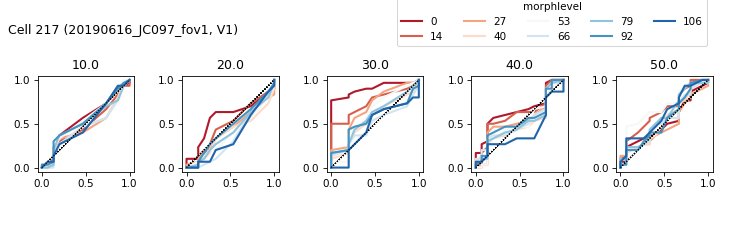

Text(0.01, 0.85, 'Cell 217 (20190616_JC097_fov1, V1)')

In [78]:
cmap='plasma' if param=='morphstep' else 'RdBu'
lw=2
# Plot----
mdiffs = sorted(aucs[param].unique())
mdiff_colors = sns.color_palette(cmap, n_colors=len(mdiffs))
colors = dict((k, v) for k, v in zip(mdiffs, mdiff_colors))

fig, axn = pl.subplots(1, len(sizes), figsize=(10,3))    
for mi, (sz, mp) in enumerate(resp_cfgs1):
    si = sizes.index(sz)
    ax=axn[si]
    if param=='morphstep':
        ax.plot(p_fas[mi, :], p_hits[mi, :], color=colors[mp], label=mp, lw=lw)
    else:
        ax.plot(p_fas[si, :], p_hits[mi, :], color=colors[mp], label=mp, lw=lw)
    ax.set_title(sz)
    ax.set_aspect('equal')
    ax.plot([0, 1], [0, 1], linestyle=':', color='k', lw=1)
ax.legend(bbox_to_anchor=(1, 1.25), loc='lower right', title=param, ncol=5)
pl.subplots_adjust(left=0.05, right=0.95, bottom=0.2, hspace=0.5, wspace=0.5, top=0.7)
fig.text(0.01, 0.85, 'Cell %i (%s, %s)' % (rid, dk, va), fontsize=12)


In [29]:
importlib.reload(ps.psigniplot)

<module 'psignifit.psigniplot' from '/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/psignifit/psigniplot.py'>

In [79]:
# aucs, p_hits, p_fas, resp_cfgs1 = get_auc_AB(rdf, param=param, n_crit=50, reverse_eff=False,
#                   class_a=0, class_b=106, return_probs=True)

curr_sz=30
auc_ = aucs[aucs['size']==curr_sz].copy()
auc_['n_chooseB'] = auc_['AUC']*auc_['n_trials']
data_ = data_matrix_from_auc(auc_, param=param,normalize=True)
data_

array([[ 0.        , 28.        , 30.        ],
       [ 0.13207547, 24.        , 30.        ],
       [ 0.25471698, 23.        , 30.        ],
       [ 0.37735849, 20.        , 30.        ],
       [ 0.5       , 22.        , 30.        ],
       [ 0.62264151, 19.        , 30.        ],
       [ 0.74528302, 21.        , 30.        ],
       [ 0.86792453, 20.        , 30.        ],
       [ 1.        , 21.        , 30.        ]])

<IPython.core.display.Javascript object>


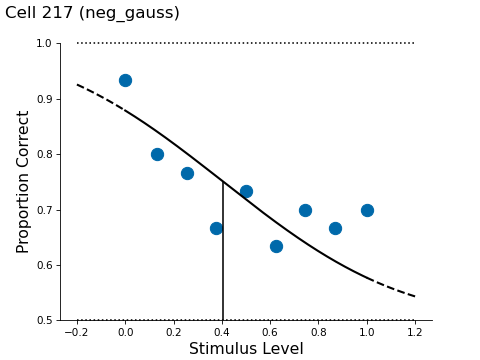

(array([], dtype=int64),)
[0.41 1.92 0.   0.5  0.  ]


/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/psignifit/psignifit.py:717: UserWarning: The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.
  warnings.warn('The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.')


Text(0.01, 0.95, 'Cell 217 (neg_gauss)')

In [82]:
fig, ax = pl.subplots()
ni = 0
opts = dict()
opts['sigmoidName'] = sigmoid_

opts['expType'] = '2AFC' #'2AFC'
opts['threshPC'] = 0.5
at_pc = 0.75 if opts['expType']=='2AFC' else 0.5
res_ = ps.psignifit(data_, opts)
print(res_['Fit'].round(2))
# norm: [0.74 1.27 0.   0.5  0.  ]
# gumbel: [0.76 1.18 0.   0.5  0.  ]
# neg_gumbel: [0.16 0.69 0.   0.5  0.  ]

# Weibull: [0.88 0.5  0.   0.5  0.  ]
# [0.78 0.91 0.   0.5  0.  ]
thr = ps.getThreshold(res_, at_pc)[0] # Value at which function reaches at_pc correct
slp = ps.getSlope(res_, ps.getThreshold(res_, at_pc)[0]) # Slope at given stimulus level

info_str = '(%i) %i (thr=%.2f,slope=%.2f)' % (ni, curr_sz, thr, slp)
ax = ps.psigniplot.plotPsych(res_, axisHandle=ax, plotData=True, 
                             lineColor='k', label=info_str)
fig.text(0.01, 0.95, 'Cell %i (%s)' % (rid, sigmoid_), fontsize=16)

In [20]:
va, dk

('V1', '20190616_JC097_fov1')

In [83]:
# fig, ax = pl.subplots()

# for ni in range(10):
#     aucs, p_hits, p_fas, resp_cfgs1 = get_auc_AB(rdf, param=param, n_crit=50, reverse_eff=True,
#                       class_a=0, class_b=106, return_probs=True)

#     curr_sz=30
#     auc_ = aucs[aucs['size']==curr_sz].copy()
#     auc_['n_chooseB'] = auc_['AUC']*auc_['n_trials']
#     data_ = data_matrix_from_auc(auc_, param=param,normalize=True)


#     opts = dict()
#     opts['sigmoidname'] = 'gumbel'
#     opts['expType'] = '2AFC' #'2AFC'
#     opts['threshPC'] = 0.5
#     at_pc = 0.75 if opts['expType']=='2AFC' else 0.5
#     res_ = ps.psignifit(data_, opts)
#     print(res_['Fit'].round(2))
#     # norm: [0.59 1.54 0.   0.5  0.  ]
#     # gumbel: [0.59 1.54 0.   0.5  0.  ]
#     # Weibull: [0.88 0.5  0.   0.5  0.  ]

#     info_str = '(%i) %i (thr=%.2f,slope=%.2f)' % (ni, curr_sz, thr, slp)
#     ax = ps.psigniplot.plotPsych(res_, axisHandle=ax, plotData=True, 
#                                  lineColor=size_colors[curr_sz], label=info_str)


## Fit by size - test 1 cell

In [32]:
cols = sns.color_palette('plasma', n_colors=5)
size_colors = dict((k, v) for k, v in zip(sizes, cols))

In [94]:
va = 'V1'
dk = '20190616_JC097_fov1'
rid = 217

aucs = AUC[(AUC.visual_area==va) & (AUC.datakey==dk) & (AUC['cell']==rid)].copy()
aucs.head()

,cell,level_1,index,AUC,morphlevel,size,n_trials,Eff,visual_area,datakey
99765,217,0,0,0.511111,0,10.0,30,0,V1,20190616_JC097_fov1
99766,217,1,1,0.452222,14,10.0,30,0,V1,20190616_JC097_fov1
99767,217,2,2,0.414444,27,10.0,30,0,V1,20190616_JC097_fov1
99768,217,3,3,0.416667,40,10.0,30,0,V1,20190616_JC097_fov1
99769,217,4,4,0.500000,53,10.0,30,0,V1,20190616_JC097_fov1


In [95]:
opts = dict()
# opts['sigmoidName'] = sigmoid_
sig='norm'
opts['expType'] = '2AFC' #'2AFC'
opts['threshPC'] = 0.5
at_pc = 0.75 if opts['expType']=='2AFC' else 0.5
#res_ = ps.psignifit(data_, opts)

<IPython.core.display.Javascript object>


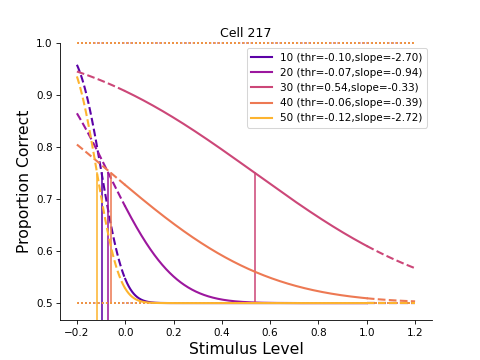

(array([], dtype=int64),)


/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/psignifit/psignifit.py:717: UserWarning: The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.
  warnings.warn('The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.')


(array([], dtype=int64),)


/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/psignifit/psignifit.py:717: UserWarning: The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.
  warnings.warn('The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.')


(array([], dtype=int64),)


/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/psignifit/psignifit.py:717: UserWarning: The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.
  warnings.warn('The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.')


(array([], dtype=int64),)


/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/psignifit/psignifit.py:717: UserWarning: The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.
  warnings.warn('The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.')


(array([], dtype=int64),)


/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/psignifit/psignifit.py:717: UserWarning: The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.
  warnings.warn('The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.')


In [96]:
cols = sns.color_palette('plasma', n_colors=5)
size_colors = dict((k, v) for k, v in zip(sizes, cols))


size_res={}
fig, ax = pl.subplots()
for curr_sz in sizes:
    auc_ = aucs[aucs['size']==curr_sz].copy()
    auc_['n_chooseB'] = auc_['AUC']*auc_['n_trials']
    Eff = int(auc_['Eff'].unique())
    sigmoid_ = 'neg_%s' % sig if Eff==0 else sig
    opts['sigmoidName'] = sigmoid_
    
    data_ = data_matrix_from_auc(auc_, param=param, normalize=True)
    res_ = ps.psignifit(data_, opts)
    try:
        thr = ps.getThreshold(res_, at_pc)[0] # Value at which function reaches at_pc correct
        slp = ps.getSlope(res_, ps.getThreshold(res_, at_pc)[0]) # Slope at given stimulus level
    except Exception as e:
        continue
#     print(curr_sz, thr, slp)
    info_str = '%i (thr=%.2f,slope=%.2f)' % (curr_sz, thr, slp)
    ax = ps.psigniplot.plotPsych(res_, axisHandle=ax, plotData=False, 
                                 lineColor=size_colors[curr_sz], label=info_str)
    size_res[curr_sz] = res_
    
ax.set_title('Cell %i' % (rid))
ax.legend()

In [70]:
mAUC.groupby(['visual_area', 'datakey', 'cell']).max()

level_1       AUC  morphlevel  size  \
visual_area datakey             cell                                        
Li          20190422_JC076_fov1 76         44  0.785556         106  50.0   
                                80         44  0.671111         106  50.0   
                                81         44  0.811111         106  50.0   
                                119        44  0.660000         106  50.0   
                                135        44  0.683333         106  50.0   
...                                       ...       ...         ...   ...   
V1          20191006_JC110_fov1 364        44  0.714533         106  50.0   
                                375        44  0.653298         106  50.0   
                                380        44  0.797683         106  50.0   
                                383        44  0.641003         106  50.0   
                                390        44  0.729779         106  50.0   

                                      n_trials  Eff  
visual_area datakey             cell                 
Li          20190422_JC076_fov1 76          30  106  
                                80          30    0  
                                81          30    0  
                                119         30    0  
                                135         30    0  
...                                        ...  ...  
V1          20191006_JC110_fov1 364         34  106  
                                375         34  106  
                                380         34  106  
                                383         34  106  
                                390         34  106  

[2763 rows x 6 columns]

##### baseline is baseline

In [497]:
# # ---------------

# def get_auc(rdf, n_crit=50):
#     #cfgs = sorted(rdf['config'].unique())
#     #rid = float(rdf['cell'].unique())
#     resp_stim = [g['response'].values for c, g in  rdf.groupby(['config'])]
#     resp_bas = [g['baseline'].values for c, g in  rdf.groupby(['config'])]
#     cfgs = [c for c, g in  rdf.groupby(['config'])]
#     n_conditions = len(resp_stim)
#     p_hits, p_fas, crit_vals = get_hits_and_fas(resp_stim, resp_bas, n_crit=n_crit)

#     true_auc = [-np.trapz(p_hits[ci, :], x=p_fas[ci, :]) for ci in np.arange(0, n_conditions)]
#     aucs = pd.DataFrame({'AUC': true_auc, 'config': cfgs})
    
#     return aucs, p_hits, p_fas

# Test fit -- all cells in 1 fov

In [142]:
import psignifit as ps

In [91]:
va='V1'
dk = '20190616_JC097_fov1'

aucs = mAUC[(mAUC.visual_area==va) & (mAUC.datakey==dk)].copy()
# aucs = mAUC[(mAUC.visual_area==va)].copy()

aucs.head()
print(aucs.shape)

(8280, 9)


In [92]:
max_auc=0.7
pass_cells = aucs[aucs['AUC']>=max_auc]['cell'].unique()
print("%i of %i cells pass crit (%.2f)" % (len(pass_cells), len(aucs['cell'].unique()), max_auc))
pass_auc = aucs[aucs['cell'].isin(pass_cells)].copy()

101 of 184 cells pass crit (0.70)


In [113]:
best_config_only=False

if best_config_only:
    # Best config (size) for each cell
    max_auc_ixs = pass_auc.groupby(['cell'])['AUC'].transform(max) == pass_auc['AUC']
    best_sz_per_cell = [(r, c) for (r, c), g in pass_auc[max_auc_ixs].groupby(['cell', 'size'])]
    assert len(pass_cells)==len(best_sz_per_cell)
    best_auc = pd.concat([g for (r,c), g in pass_auc.groupby(['cell', 'size']) if (r, c) in best_sz_per_cell])
else:
    best_auc = pass_auc.copy()
    
best_auc.head()


,cell,level_1,AUC,morphlevel,size,n_trials,Eff,visual_area,datakey
95535,9,0,0.555556,0,10.0,30,0,V1,20190616_JC097_fov1
95536,9,1,0.481111,14,10.0,30,0,V1,20190616_JC097_fov1
95537,9,2,0.508889,27,10.0,30,0,V1,20190616_JC097_fov1
95538,9,3,0.555556,40,10.0,30,0,V1,20190616_JC097_fov1
95539,9,4,0.494444,53,10.0,30,0,V1,20190616_JC097_fov1


In [94]:
importlib.reload(ps)

<module 'psignifit' from '/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/psignifit/__init__.py'>

In [115]:
opts = dict()
sig = 'norm'

opts['expType'] = '2AFC' #'2AFC'
opts['threshPC'] = 0.5
at_pc = 0.75 if opts['expType']=='2AFC' else 0.5

In [ ]:
results=dict((k, {s: None}) for (k, s), g in best_auc.groupby(['cell', 'size']))

d_=[]

conds = [(r, s) for (r, s), g in best_auc.groupby(['cell', 'size'])]

for ri, ((rid, sz), auc_r) in enumerate(best_auc.groupby(['cell', 'size'])):
    if ri%10==0:
        print("...%i of %i " % (int(ri+1), len(conds)))
        
    Eff = int(auc_r['Eff'].unique())
    sigmoid_ = 'neg_%s' % sig if Eff==0 else sig
    opts['sigmoidName'] = sigmoid_
    
    data = data_matrix_from_auc(auc_r, param=param)
    res = ps.psignifit(data, opts)
    results[rid][sz] = res
    df_ = pd.DataFrame(res['Fit'], index=param_names, columns=[rid]).T
    try:
        thr = ps.getThreshold(res, 0.75)[0] # Value at which function reaches at_pc correct
        slp = ps.getSlope(res, ps.getThreshold(res, 0.75)[0]) # Slope at given stimulus level
    except Exception as e:
        thr=None
        slp=None
    df_['slope'] = slp
    df_['thr'] = thr
    df_['cell'] = rid
    df_['size'] = sz
    df_['sigmoid'] = sigmoid_
    
    d_.append(df_)


...1 of 505 
HANDLE: <function getSigmoidHandle.<locals>.<lambda> at 0x7f9a3e9b7320>


/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/psignifit/psignifit.py:717: UserWarning: The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.
  CI = np.zeros([len(result['options']['confP']),2])


HANDLE: <function getSigmoidHandle.<locals>.<lambda> at 0x7f9a3e9b78c0>
HANDLE: <function getSigmoidHandle.<locals>.<lambda> at 0x7f9a3e9b7e60>
HANDLE: <function getSigmoidHandle.<locals>.<lambda> at 0x7f9a3e1b0440>
HANDLE: <function getSigmoidHandle.<locals>.<lambda> at 0x7f9a3e1b09e0>
HANDLE: <function getSigmoidHandle.<locals>.<lambda> at 0x7f9a3e1b0f80>
HANDLE: <function getSigmoidHandle.<locals>.<lambda> at 0x7f9a3e13a560>
HANDLE: <function getSigmoidHandle.<locals>.<lambda> at 0x7f9a3e13ab00>
HANDLE: <function getSigmoidHandle.<locals>.<lambda> at 0x7f9a3e1380e0>
HANDLE: <function getSigmoidHandle.<locals>.<lambda> at 0x7f9a3e138680>
...11 of 505 
HANDLE: <function getSigmoidHandle.<locals>.<lambda> at 0x7f9a3e138b90>
HANDLE: <function getSigmoidHandle.<locals>.<lambda> at 0x7f9a3e13c200>
HANDLE: <function getSigmoidHandle.<locals>.<lambda> at 0x7f9a3e13c7a0>
HANDLE: <function getSigmoidHandle.<locals>.<lambda> at 0x7f9a3e13cd40>
HANDLE: <function getSigmoidHandle.<locals>.<lambd

HANDLE: <function getSigmoidHandle.<locals>.<lambda> at 0x7f9a3e680320>
HANDLE: <function getSigmoidHandle.<locals>.<lambda> at 0x7f9a3e6808c0>
HANDLE: <function getSigmoidHandle.<locals>.<lambda> at 0x7f9a3e680e60>
HANDLE: <function getSigmoidHandle.<locals>.<lambda> at 0x7f9a3e68e440>
HANDLE: <function getSigmoidHandle.<locals>.<lambda> at 0x7f9a3e68e9e0>
HANDLE: <function getSigmoidHandle.<locals>.<lambda> at 0x7f9a3e68ef80>
HANDLE: <function getSigmoidHandle.<locals>.<lambda> at 0x7f9a3e698560>
...121 of 505 
HANDLE: <function getSigmoidHandle.<locals>.<lambda> at 0x7f9a3e698a70>
HANDLE: <function getSigmoidHandle.<locals>.<lambda> at 0x7f9a3e6a90e0>
HANDLE: <function getSigmoidHandle.<locals>.<lambda> at 0x7f9a3e6a9680>
HANDLE: <function getSigmoidHandle.<locals>.<lambda> at 0x7f9a3e6a9c20>
HANDLE: <function getSigmoidHandle.<locals>.<lambda> at 0x7f9a3e6b6200>
HANDLE: <function getSigmoidHandle.<locals>.<lambda> at 0x7f9a3e6b67a0>
HANDLE: <function getSigmoidHandle.<locals>.<lamb

In [134]:
estimates = pd.concat(d_, axis=0)
print(estimates.shape)
estimates.head()

(505, 10)


,threshold,width,lambda,gamma,eta,slope,thr,cell,size,sigmoid
9,-8.134347,25.742626,1.770664e-06,0.5,3.626514e-05,-0.025491,-8.134382,9,10.0,neg_norm
9,-13.307578,128.357960,2.676204e-13,0.5,6.116363e-06,-0.005112,-13.307578,9,20.0,neg_norm
9,-14.975346,110.056106,1.325393e-12,0.5,1.794314e-13,-0.005962,-14.975346,9,30.0,neg_norm
9,-10.370745,25.732207,7.373378e-12,0.5,2.267188e-05,-0.025501,-10.370745,9,40.0,neg_norm
9,-13.914133,187.301629,5.924162e-13,0.5,1.256341e-07,-0.003503,-13.914133,9,50.0,neg_norm


In [135]:
max_x

106.0

In [136]:
max_x = float(aucs[param].max())

pass_estimates = estimates[(estimates['threshold']>=0) & (estimates['threshold']<=max_x)].dropna()

fit_cells = pass_estimates.index.tolist()
print('%i cells with valid fits' % len(fit_cells))

72 cells with valid fits


<IPython.core.display.Javascript object>


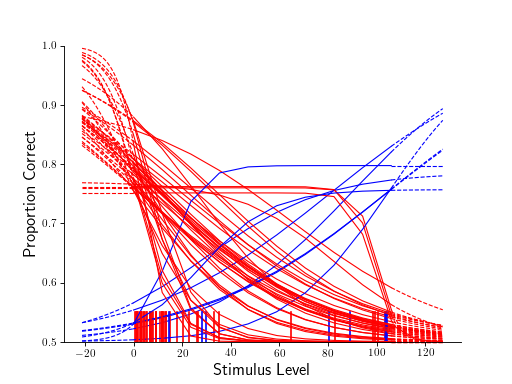

In [103]:

fig, ax = pl.subplots()
for ri, est in pass_estimates.groupby(['size']):
    ai = ax
    res = results[ri]
    lcolor = [1, 0, 0] if 'neg_' in res['options']['sigmoidName'] else [0, 0, 1]
    ps.psigniplot.plotPsych(res, axisHandle=ax, plotData=False, lineWidth=1, plotAsymptote=False,
                               thresh_height=0.55, npoints=10, lineColor=lcolor)

<IPython.core.display.Javascript object>


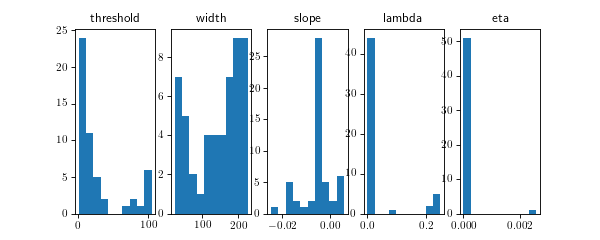

In [109]:
plot_params = ['threshold', 'width', 'slope', 'lambda', 'eta']
fig, axn = pl.subplots(1, len(plot_params), figsize=(len(plot_params)*1.5, 3))
for ax, p in zip(axn.flat, plot_params):
    sns.histplot(pass_estimates[p], hue='')

In [111]:
pass_estimates.head()

,threshold,width,lambda,gamma,eta,slope,thr,cell
11,29.723928,145.238698,2.140558e-01,0.5,3.959836e-13,0.001274,77.558080,11
12,17.767120,217.660086,3.096635e-07,0.5,1.389371e-12,-0.003382,17.767074,12
15,7.449973,148.529284,1.099547e-07,0.5,2.704609e-12,-0.004956,7.449962,15
16,100.466721,24.670966,2.396872e-01,0.5,1.953780e-11,-0.002364,87.110532,16
24,0.904706,136.592730,5.038400e-12,0.5,2.964760e-13,-0.005389,0.904706,24


In [107]:

# def split_datakey_str(s):
#     session, animalid, fovn = s.split('_')
#     fovnum = int(fovn[3:])
#     return session, animalid, fovnum



# def get_tracedir_from_datakey(datakey, experiment='blobs', rootdir='/n/coxfs01/2p-data', traceid='traces001'):
#     session, animalid, fovn = split_datakey_str(datakey)
    
#     darray_dirs = glob.glob(os.path.join(rootdir, animalid, session, 'FOV%i_zoom2p0x' % fovn,
#                             'combined_%s_static' % experiment, 'traces', 
#                              '%s*' % traceid, 'data_arrays', 'np_subtracted.npz'))
    
#     assert len(darray_dirs)==1, "More than 1 data array dir found: %s" % str(darray_dirs)
    
#     traceid_dir = darray_dirs[0].split('/data_arrays')[0]
#     return traceid_dir

In [115]:
max_auc=0.7
opts = dict()
sig = 'gauss'

opts['expType'] = '2AFC' #'2AFC'
opts['threshPC'] = 0.5
at_pc = 0.75 if opts['expType']=='2AFC' else 0.5

dk = '20190616_JC097_fov1'
va = 'V1'

currAUC = AUC[(AUC.visual_area==va) & (AUC.datakey==dk)].copy()

for (va, dk), currAUC in AUC.groupby(['datakey']):
    traceid_dir = get_tracedir_from_datakey(dk)
    curr_dst_dir = os.path.join(traceid_dir, 'neurometric', 'fits')
    if not os.path.exists(curr_dst_dir):
        os.makedirs(curr_dst_dir)
    print("Saving ROI results to:\n   %s" % curr_dst_dir)

    # Cells that pass performance criterion
    pass_cells = currAUC[currAUC['AUC']>=max_auc]['cell'].unique()

    print("%i of %i cells pass crit (%.2f)" % (len(pass_cells), len(currAUC['cell'].unique()), max_auc))
    pass_auc = currAUC[currAUC['cell'].isin(pass_cells)].copy()
    if len(pass_cells)==0:
        print("****[%s, %s] no cells." % (va, dk))

    for rid, auc_r in pass_auc.groupby(['cell']):
        fn = '%s_rid%03d.pkl' % (sigmoid_, rid)
        outfile = os.path.join(curr_dst_dir, fn)
        if os.path.exists(outfile):
            continue

        results={}
        for sz, auc_sz in auc_r.groupby(['size']):
            # format data
            data = data_matrix_from_auc(auc_sz, param=param)

            # fit
            Eff = int(auc_r['Eff'].unique())
            sigmoid_ = 'neg_%s' % sig if Eff==0 else sig

            opts['sigmoidName'] = sigmoid_
            res = ps.psignifit(data, opts)
            results[sz] = res

        fn = '%s_rid%03d.pkl' % (sigmoid_, rid)
        outfile = os.path.join(curr_dst_dir, fn)

        with open(outfile, 'wb') as f:
            pkl.dump(results, f, protocol=2)
        print("... saved: %s" % fn)


Saving ROI results to: /n/coxfs01/2p-data/JC097/20190616/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_d1a2cd_traces001_a13a76_traces001_0a4432_traces001_6fc2ca_traces001_2449cf_traces001_70650b/neurometric/fits
104 of 184 cells pass crit (0.70)
(array([], dtype=int64),)


/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
... saved: neg_gauss_rid000.pkl
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
... saved: neg_gauss_rid009.pkl
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
... saved: neg_gauss_rid015.pkl
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
... saved: neg_gauss_rid016.pkl
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
... saved: neg_gauss_rid017.pkl
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
... saved: neg_gauss_rid037.pkl
(array([], dtype=int64),)
(array([], dtype=int64),)
(a

(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
... saved: neg_gauss_rid219.pkl
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
... saved: gauss_rid221.pkl
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
... saved: neg_gauss_rid223.pkl
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
... saved: neg_gauss_rid224.pkl
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
... saved: neg_gauss_rid232.pkl
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
... saved: neg_gauss_rid233.pkl
(array([], dtype=int64),)
(array([], dtype=int64),)
(array

(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
... saved: neg_gauss_rid424.pkl
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
... saved: neg_gauss_rid425.pkl


In [130]:
os.listdir(curr_dst_dir)

['neg_gauss_rid217.pkl',
 'neg_gauss_rid000.pkl',
 'neg_gauss_rid009.pkl',
 'neg_gauss_rid015.pkl',
 'neg_gauss_rid016.pkl',
 'neg_gauss_rid017.pkl',
 'neg_gauss_rid037.pkl',
 'neg_gauss_rid045.pkl',
 'neg_gauss_rid050.pkl',
 'neg_gauss_rid054.pkl',
 'neg_gauss_rid062.pkl',
 'neg_gauss_rid063.pkl',
 'neg_gauss_rid064.pkl',
 'gauss_rid065.pkl',
 'neg_gauss_rid068.pkl',
 'neg_gauss_rid069.pkl',
 'neg_gauss_rid081.pkl',
 'neg_gauss_rid087.pkl',
 'gauss_rid090.pkl',
 'neg_gauss_rid106.pkl',
 'neg_gauss_rid108.pkl',
 'neg_gauss_rid109.pkl',
 'gauss_rid117.pkl',
 'gauss_rid132.pkl',
 'neg_gauss_rid141.pkl',
 'neg_gauss_rid142.pkl',
 'neg_gauss_rid143.pkl',
 'neg_gauss_rid144.pkl',
 'neg_gauss_rid145.pkl',
 'gauss_rid147.pkl',
 'neg_gauss_rid150.pkl',
 'neg_gauss_rid153.pkl',
 'neg_gauss_rid156.pkl',
 'neg_gauss_rid157.pkl',
 'neg_gauss_rid165.pkl',
 'neg_gauss_rid168.pkl',
 'neg_gauss_rid170.pkl',
 'neg_gauss_rid171.pkl',
 'neg_gauss_rid173.pkl',
 'neg_gauss_rid185.pkl',
 'neg_gauss_rid187.p

In [116]:
dk
traceid_dir = get_tracedir_from_datakey(dk)
print(traceid_dir)

/n/coxfs01/2p-data/JC097/20190616/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_d1a2cd_traces001_a13a76_traces001_0a4432_traces001_6fc2ca_traces001_2449cf_traces001_70650b


In [127]:
# Cells that pass performance criterion
pass_cells = currAUC[currAUC['AUC']>=max_auc]['cell'].unique()
print("%i of %i cells pass crit (%.2f)" % (len(pass_cells), len(currAUC['cell'].unique()), max_auc))
pass_auc = currAUC[currAUC['cell'].isin(pass_cells)].copy()
if len(pass_cells)==0:
    print("****[%s, %s] no cells." % (va, dk))


# Best config (size) for each cell
max_auc_ixs = pass_auc.groupby(['cell'])['AUC'].transform(max) == pass_auc['AUC']
ix = pass_auc[max_auc_ixs]['cell'].drop_duplicates().index.tolist()
best_sz_per_cell = [(r, c) for (r, c), g in pass_auc.loc[ix].groupby(['cell', 'size'])]
assert len(pass_cells)==len(best_sz_per_cell)
if len(best_sz_per_cell)==0:
    print("****[%s, %s] no cells." % (va, dk))

best_auc = pd.concat([g for (r,c), g in pass_auc.groupby(['cell', 'size']) if (r, c) in best_sz_per_cell])


104 of 184 cells pass crit (0.70)


<IPython.core.display.Javascript object>


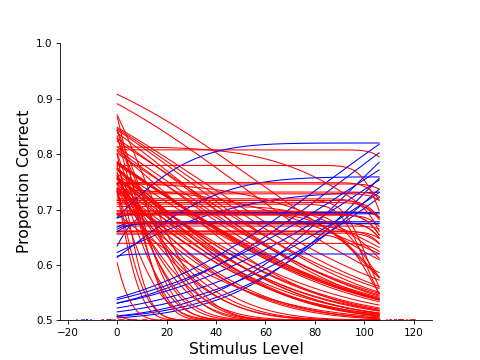

/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/psignifit/psignifit.py:717: UserWarning: The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.
  warnings.warn('The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.')
/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/psignifit/psignifit.py:717: UserWarning: The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.
  warnings.warn('The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.')
/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/psignifit/psignifit.py:717: UserWarning: The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.
  warnings.warn('The CIs computed by this method are only upper bo

/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/psignifit/psignifit.py:717: UserWarning: The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.
  warnings.warn('The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.')
/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/psignifit/psignifit.py:717: UserWarning: The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.
  warnings.warn('The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.')
/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/psignifit/psignifit.py:717: UserWarning: The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.
  warnings.warn('The CIs computed by this method are only upper bo

/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/psignifit/psignifit.py:717: UserWarning: The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.
  warnings.warn('The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.')
/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/psignifit/psignifit.py:717: UserWarning: The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.
  warnings.warn('The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.')
/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/psignifit/psignifit.py:717: UserWarning: The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.
  warnings.warn('The CIs computed by this method are only upper bo

In [139]:
param_names = ['threshold', 'width', 'lambda', 'gamma', 'eta']

fig, ax = pl.subplots()

d_ = []

for r, g in best_auc.groupby(['cell']):

    fn = glob.glob(os.path.join(traceid_dir, 'neurometric', 'fits', '*_rid%03d.pkl' % r))[0]
    with open(fn, 'rb') as f:
        curr_res = pkl.load(f)
    curr_sz = int(g['size'].unique())
    res = curr_res[curr_sz]
    color= [1, 0, 0] if 'neg' in res['options']['sigmoidName'] else [0, 0, 1]
    ps.psigniplot.plotPsych(res, axisHandle=ax, plotData=False, lineWidth=1, plotAsymptote=False,
                               thresh_height=0.1, npoints=500, extrapolLength=0, lineColor=color)
    
        
    df_ = pd.DataFrame(res['Fit'], index=param_names, columns=[r]).T
    try:
        thr = ps.getThreshold(res, 0.75)[0] # Value at which function reaches at_pc correct
        slp = ps.getSlope(res, ps.getThreshold(res, 0.75)[0]) # Slope at given stimulus level
    except Exception as e:
        thr=None
        slp=None
    df_['slope'] = slp
    df_['thr'] = thr
    df_['cell'] = r
    df_['size'] = curr_sz
    d_.append(df_)
    
est = pd.concat(d_, axis=0)

In [134]:
res.keys()

dict_keys(['X1D', 'marginals', 'marginalsX', 'marginalsW', 'Posterior', 'logPmax', 'weight', 'integral', 'Fit', 'options', 'data', 'conf_Intervals', 'timestamp'])

In [691]:
max_auc=0.7
opts = dict()
sig = 'logistic'

opts['expType'] = '2AFC' #'2AFC'
opts['threshPC'] = 0.5
at_pc = 0.75 if opts['expType']=='2AFC' else 0.5

e_=[]
R = dict((k, {v: None}) for (k, v), g in mAUC.groupby(['visual_area', 'datakey']))

for (va, dk), aucs in AUC.groupby(['visual_area', 'datakey']):

    #aucs = mAUC[(mAUC.visual_area==va)].copy()
    if dk in R[va].keys() and isinstance(R[va][dk], dict): #@ is not None:
        continue
        
    traceid_dir = get_tracedir_from_datakey(dk)
    curr_dst_dir = os.path.join(traceid_dir, 'neurometric', 'fits')
    if not os.path.exists(curr_dst_dir):
        os.makedirs(cur_dst_dir)
        
    # Cells that pass performance criterion
    pass_cells = aucs[aucs['AUC']>=max_auc]['cell'].unique()
    print("%i of %i cells pass crit (%.2f)" % (len(pass_cells), len(aucs['cell'].unique()), max_auc))
    pass_auc = aucs[aucs['cell'].isin(pass_cells)].copy()
    if len(pass_cells)==0:
        print("****[%s, %s] no cells." % (va, dk))
        continue

    # Best config (size) for each cell
#     max_auc_ixs = pass_auc.groupby(['cell'])['AUC'].transform(max) == pass_auc['AUC']
#     ix = pass_auc[max_auc_ixs]['cell'].drop_duplicates().index.tolist()
#     best_sz_per_cell = [(r, c) for (r, c), g in pass_auc.loc[ix].groupby(['cell', 'size'])]
#     assert len(pass_cells)==len(best_sz_per_cell)
#     if len(best_sz_per_cell)==0:
#         print("****[%s, %s] no cells." % (va, dk))
#         continue
#     best_auc = pd.concat([g for (r,c), g in pass_auc.groupby(['cell', 'size']) if (r, c) in best_sz_per_cell])

    
    d_=[]
    for rid, auc_r in pass_auc.groupby(['cell']):
        results={}
        for sz, auc_sz in auc_r.groupby(['size']):
            # format data
            data = data_matrix_from_auc(auc_sz, param=param)

            # fit
            Eff = int(auc_r['Eff'].unique())
            sigmoid_ = 'neg_%s' % sig if Eff==0 else sig

            opts['sigmoidName'] = sigmoid_
            res = ps.psignifit(data, opts)
            results[sz] = res
        
        outfile = os.path.join(curr_dst_dir, '%s_rid%03d.pkl' % (sigmoid_, rid))

        with open(outfile, 'wb') as f:
            pkl.dump(results, f, protocol=2)

        
        df_ = pd.DataFrame(res['Fit'], index=param_names, columns=[rid]).T
        try:
            thr = ps.getThreshold(res, 0.75)[0] # Value at which function reaches at_pc correct
            slp = ps.getSlope(res, ps.getThreshold(res, 0.75)[0]) # Slope at given stimulus level
        except Exception as e:
            thr=None
            slp=None
        df_['slope'] = slp
        df_['thr'] = thr
        d_.append(df_)
    est = pd.concat(d_, axis=0)
    est['cell'] = est.index.tolist()
    est['visual_area'] = va
    est['datakey'] = dk
    e_.append(est)
    
    R[va][dk] = results
    

0 of 6 cells pass crit (0.70)
****[V1, 20190517_JC083_fov1] no cells.
48 of 92 cells pass crit (0.70)
(array([], dtype=int64),)


/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/psignifit/psignifit.py:717: UserWarning: The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.
  warnings.warn('The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.')


(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], d

/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/psignifit/psignifit.py:717: UserWarning: The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.
  warnings.warn('The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.')


(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], d

/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/psignifit/psignifit.py:717: UserWarning: The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.
  warnings.warn('The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.')


(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], d

/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/psignifit/psignifit.py:717: UserWarning: The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.
  warnings.warn('The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.')


(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], d

/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/psignifit/psignifit.py:717: UserWarning: The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.
  warnings.warn('The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.')


(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)


In [692]:
for k, v in R.items():
    for kk, vv in v.items():
        if vv is None:
            print(k, kk, vv)

In [693]:
estimates = pd.concat(e_).reset_index(drop=True)
estimates.head()

,threshold,width,lambda,gamma,eta,slope,thr,cell,visual_area,datakey
0,4.532189,1.966370,1.557351e-10,0.5,2.685067e-09,0.333712,4.532189,186,Li,20190422_JC076_fov1
1,3.892998,1.914792,1.401999e-08,0.5,1.602869e-07,0.342701,3.892998,261,Li,20190422_JC076_fov1
2,4.509790,5.885670,5.069362e-05,0.5,9.112391e-11,0.111480,4.510017,269,Li,20190422_JC076_fov1
3,4.728790,1.927109,4.139367e-07,0.5,4.126728e-05,0.340511,4.728791,277,Li,20190422_JC076_fov1
4,4.054206,2.864205,3.899546e-05,0.5,6.835823e-11,0.229086,4.054291,292,Li,20190422_JC076_fov1


In [727]:
# res_outfile = os.path.join(src_data_dir, 'results.pkl')
# with open(res_outfile, 'wb') as f:
#     pkl.dump({'R': R, 'estimates': estimates}, f, protocol=2)

res_outfile = os.path.join(src_data_dir, 'results.pkl')
with open(res_outfile, 'wb') as f:
    pkl.dump({'estimates': estimates, 'AUC': mAUC}, f, protocol=2)

In [726]:
# jupyter notebook --NotebookApp.iopub_msg_rate_limit=10000

res_outfile = os.path.join(src_data_dir, 'R.pkl')
with open(res_outfile, 'wb') as f:
    pkl.dump({'R': R}, f, protocol=2)

AttributeError: Can't pickle local object 'normalizeFunction.<locals>.<lambda>'

In [704]:
importlib.reload(ps.psigniplot)


<module 'psignifit.psigniplot' from '/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/psignifit/psigniplot.py'>

In [ ]:
ps.psigniplot.plotPsych(res, axisHandle=ax, plotData=False, lineWidth=1, plotAsymptote=False

In [9]:
param='morphstep'
max_x = float(mAUC[param].max())
visual_areas = ['V1', 'Lm', 'Li']
print(max_x)
pass_estimates = estimates[(estimates['threshold']>=0) & (estimates['threshold']<=max_x)].dropna()

4.0


In [18]:
pass_estimates.dtypes

threshold      float64
width          float64
lambda         float64
gamma          float64
eta            float64
slope          float64
thr            float64
cell             int64
visual_area     object
datakey         object
dtype: object

106.0


<IPython.core.display.Javascript object>


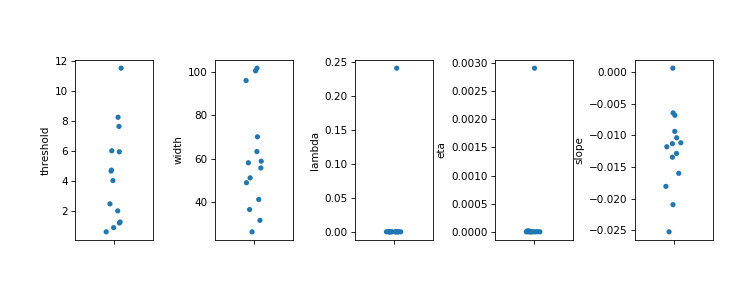

In [146]:
max_x = float(mAUC[param].max())
pass_estimates = est[(est['threshold']>=0) & (est['threshold']<=max_x)
                    & (est['width']<=max_x)].dropna()

visual_areas = ['V1', 'Lm', 'Li']
print(max_x)

param_names = ['threshold', 'width', 'lambda', 'gamma', 'eta']
plot_params = ['threshold', 'width', 'lambda', 'eta','slope']

n_params = len(param_names)

fig, axn = pl.subplots(1, len(plot_params), figsize=(len(plot_params)*2, 4))
for ax, p in zip(axn.flat, plot_params):
    sns.stripplot(y=p, data=pass_estimates, ax=ax)
    
pl.subplots_adjust(left=0.1, right=0.95, bottom=0.2, top=0.8, wspace=0.8)

<IPython.core.display.Javascript object>


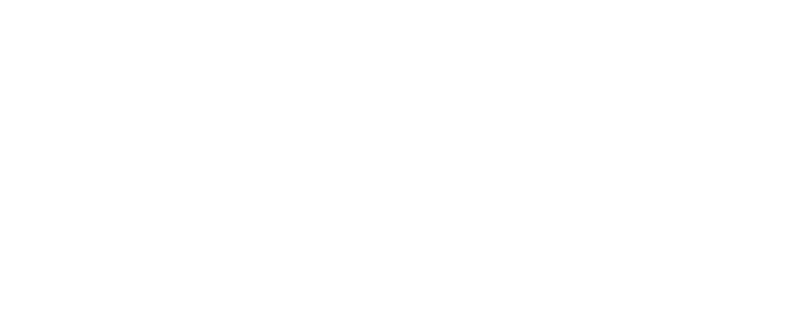

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [716]:
fig, axn = pl.subplots(1,3, figsize=(10,4))
for (va, dk), est in pass_estimates.groupby(['visual_area','datakey']):
    results = R[va][dk]
    curr_fit_cells = est['cell'].unique()
    
    ai = visual_areas.index(va)
    ax=axn[ai]
    for rid, res in results.items():
        if rid not in curr_fit_cells:
            continue
        ps.psigniplot.plotPsych(res, axisHandle=ax, plotData=False, lineWidth=1, plotAsymptote=False,
                               thresh_height=0.1, npoints=10)
    ax.set_title(va, fontsize=24)
pl.subplots_adjust(left=0.1, right=0.95, bottom=0.2, top=0.8, wspace=0.5)


<IPython.core.display.Javascript object>


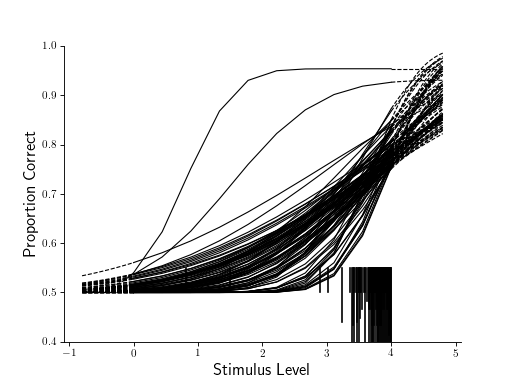

In [717]:
va='Lm'

fig, ax = pl.subplots()
for dk, est in pass_estimates[pass_estimates.visual_area==va].groupby(['datakey']):
    results = R[va][dk]
    curr_fit_cells = est['cell'].unique()
    for rid, res in results.items():
        if rid not in curr_fit_cells:
            continue
        ps.psigniplot.plotPsych(res, axisHandle=ax, plotData=False, lineWidth=1, plotAsymptote=False,
                               thresh_height=0.55, npoints=10)

<IPython.core.display.Javascript object>


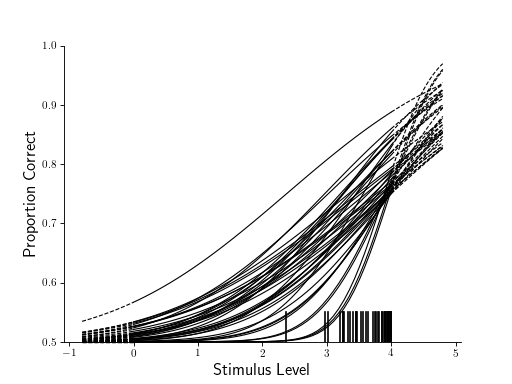

In [712]:
va='Li'

fig, ax = pl.subplots()
for dk, est in pass_estimates[pass_estimates.visual_area==va].groupby(['datakey']):
    results = R[va][dk]
    curr_fit_cells = est['cell'].unique()
    for rid, res in results.items():
        if rid not in curr_fit_cells:
            continue
        ps.psigniplot.plotPsych(res, axisHandle=ax, plotData=False, lineWidth=1, plotAsymptote=False,
                               thresh_height=0.55, npoints=50)

In [718]:
pass_estimates.head()

,threshold,width,lambda,gamma,eta,slope,thr,cell,visual_area,datakey
1,3.892998,1.914792,1.401999e-08,0.5,1.602869e-07,0.342701,3.892998,261,Li,20190422_JC076_fov1
10,3.908429,3.619414,5.050646e-11,0.5,9.843335e-10,0.181301,3.908429,37,Li,20190602_JC091_fov1
11,3.473057,7.589552,4.058454e-09,0.5,6.106602e-09,0.086461,3.473057,38,Li,20190602_JC091_fov1
12,3.524935,7.561378,1.453119e-08,0.5,3.145398e-10,0.086783,3.524935,39,Li,20190602_JC091_fov1
13,3.904229,5.447926,6.400028e-08,0.5,2.762301e-11,0.120450,3.904230,40,Li,20190602_JC091_fov1


In [10]:
mean_est = pass_estimates.groupby(['visual_area', 'datakey']).mean().reset_index()

<IPython.core.display.Javascript object>


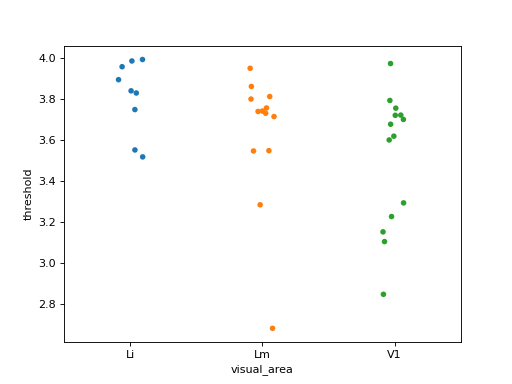

<AxesSubplot:xlabel='visual_area', ylabel='threshold'>

In [11]:
fig, ax = pl.subplots()
sns.stripplot(x='visual_area', y='threshold', data=mean_est, ax=ax)

<IPython.core.display.Javascript object>


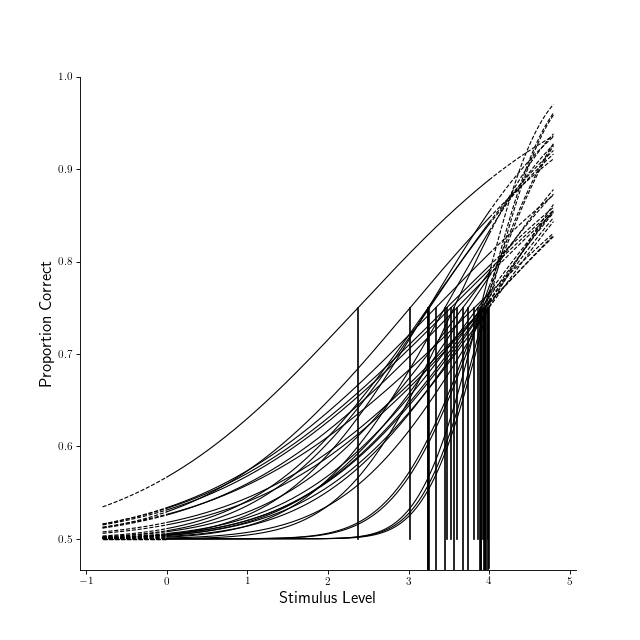

<IPython.core.display.Javascript object>


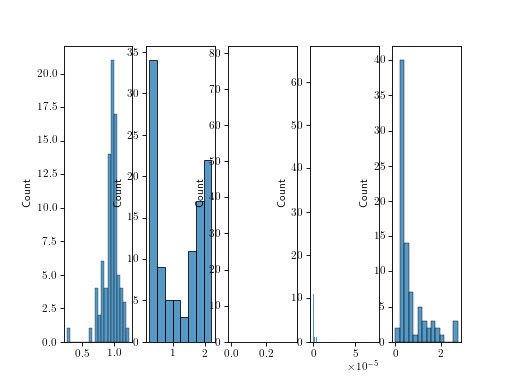

In [371]:
fig, axn = pl.subplots(1, n_params)
for ax, p in zip(axn.flat, ['threshold', 'width', 'lambda', 'eta', 'slope']):
    sns.histplot(data=estimates[p].values, ax=ax)



# Stimuli

In [40]:
morphlevels = SDF['20190616_JC097_fov1']['morphlevel'].unique()
stimdir = '/n/coxfs01/behavior-data/stimuli/D1D2M105_yrot_fine_steps/final'
curr_morphs = [m for m in sorted(morphlevels) if m!=-1]

image_fns = [os.path.join(stimdir, 'morph%i_y0.png' % m) for m in curr_morphs]
images={}
for m, fn in zip(curr_morphs, image_fns):
    images[m] = pl.imread(fn)

In [45]:
morph_lut, a_morphs, b_morphs = get_morph_levels()


In [46]:
morph_steps={}
for k, v in morph_lut.items():
    if v not in morph_steps.keys():
        morph_steps[v] =[]
    morph_steps[v].append(k)
morph_steps

{1: [40, 66], 2: [27, 79], 3: [14, 92], 4: [0, 106], 0: [53], -1: [-1]}

In [47]:
morphsteps = sorted([k for k, v in morph_steps.items() if k>=0])
morphsteps

[0, 1, 2, 3, 4]

<IPython.core.display.Javascript object>


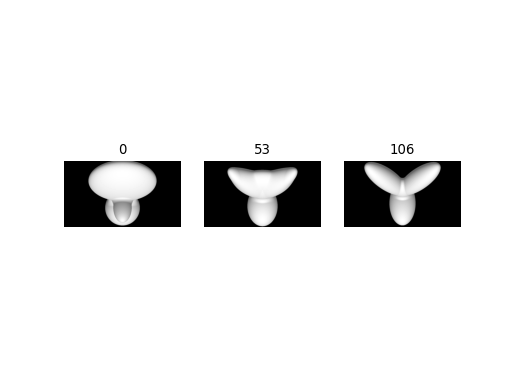

In [48]:
fig, axn = pl.subplots(1,3)
for ax, m in zip(axn.flat, [0, 53, 106]):
    ax.imshow(images[m], cmap='gray')
    ax.set_title(m)
    ax.axis('off')

<IPython.core.display.Javascript object>


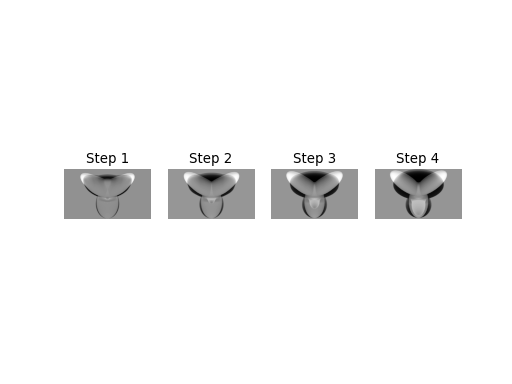

In [51]:
fig, axn = pl.subplots(1, len(morphsteps)-1)
diffs = {}
d=[]
for mstep, mims in morph_steps.items():
    if mstep <=0:
        continue
    ai = mstep-1
    ax = axn[ai]
    im1 = images[mims[0]]
    im2 = images[mims[1]] 
    diff_im = im1 - im2
    ax.imshow(diff_im, cmap='Greys')
    ax.axis('off')
    d.append(np.sum(diff_im))
    
    ediff = sp.spatial.distance.euclidean(im1.ravel(), im2.ravel())
    
    diffs[mstep] = ediff
    ax.set_title("Step %i" % mstep)
diffs.update({0: 0})


<IPython.core.display.Javascript object>


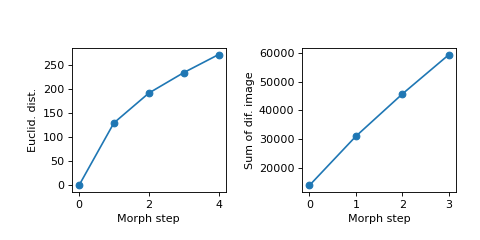

In [56]:
fig, axn = pl.subplots(1,2, figsize=(6,3))
ax=axn[0]
ax.plot(morphsteps, [diffs[v] for v in morphsteps], marker='o')
ax.set_xlabel('Morph step')
ax.set_ylabel('Euclid. dist.')

ax=axn[1]
ax.plot(d, marker='o')
ax.set_xlabel('Morph step')
ax.set_ylabel('Sum of dif. image')

pl.subplots_adjust(left=0.15, right=0.95, bottom=0.2, wspace=0.5, top=0.8)


In [620]:
diffs

{1: 129.56948852539062,
 2: 191.359619140625,
 3: 233.80543518066406,
 4: 271.2908630371094}

In [625]:
np.linalg.norm(im2-im1)

271.29086

<IPython.core.display.Javascript object>


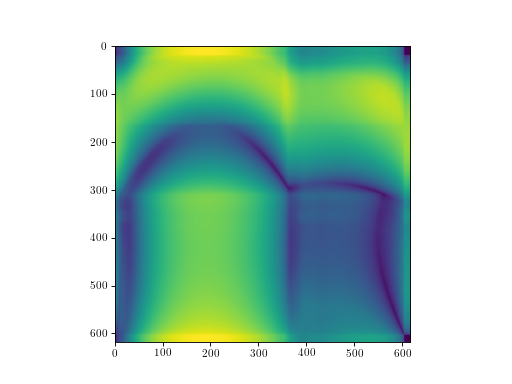

In [630]:
d1 = sp.spatial.distance.cdist(im2, im1, 'euclidean')
pl.figure()
pl.imshow(d1)

In [636]:
np.sum(diff_im)


-59371.383

In [343]:
pd.DataFrame(res['Fit'], index=param_names, columns=[rid]).T


,threshold,width,lambda,gamma,eta
217,0.807907,0.688368,1.084300e-09,0.5,2.040462e-07


In [323]:
rid = 217

auc_r = best_auc[(best_auc['cell']==rid)].copy()
data = data_matrix_from_auc(auc_r)
data

array([[ 0.        , 14.        , 30.        ],
       [ 0.13207547, 17.        , 30.        ],
       [ 0.25471698, 18.        , 30.        ],
       [ 0.37735849, 15.        , 30.        ],
       [ 0.5       , 18.        , 30.        ],
       [ 0.62264151, 17.        , 30.        ],
       [ 0.74528302, 21.        , 30.        ],
       [ 0.86792453, 23.        , 30.        ],
       [ 1.        , 28.        , 30.        ]])

In [353]:
ps.getThreshold(res, 0.75)[0] # Value at which function reaches at_pc correct
ps.getSlope(res, ps.getThreshold(res, 0.75)[0]) # Slope at given stimulus level

/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/psignifit/psignifit.py:717: UserWarning: The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.
  warnings.warn('The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.')


0.807906798155016

In [357]:
ps.getSlope(res, ps.getThreshold(res, 0.75)[0])

0.9532720278663362

In [324]:
opts = dict()
opts['sigmoidName'] = 'weibull'
opts['expType'] = '2AFC' #'2AFC'
opts['threshPC'] = 0.5
#opts['stepN']= [25,20,10,20]  #[40,40,50,20,20]
#  [threshold, width, upper asymptote, lower asymptote, variance scaling] 
# opts['borders'] = bounds
# opts['moveBorders'] = False
# opts['priors'] = priors
res = ps.psignifit(data, opts)


(array([], dtype=int64),)


/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [21]:
param_names = ['threshold', 'width', 'lambda', 'gamma', 'eta']
n_params = len(param_names)
#first lets have a look at the results with the standard prior strength:
# print('Fit:', res['Fit'].round(2))


<IPython.core.display.Javascript object>


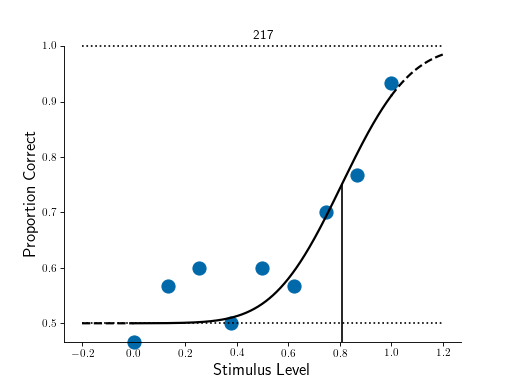

Text(0.5, 1.0, '217')

In [326]:
fig, ax = pl.subplots()
ax = ps.psigniplot.plotPsych(res, axisHandle=ax)
ax.set_title(rid)

# figname = 'psychometric_%s' % animalid
# pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
# print(curr_dst_dir, figname)

In [333]:
ps.getThreshold(res, 0.75)


(0.807906798155016,
 array([[0.57525885, 1.44231971],
        [0.6195629 , 1.24934457],
        [0.69767686, 1.00144201]]))

In [335]:
ps.getThreshold(res, 0.75, 1)

(0.9490430475764219,
 array([[0.63759465, 1.35223187],
        [0.69325121, 1.27614412],
        [0.80064194, 1.13613742]]))

In [334]:
ps.getSlope(res, 0.75)


0.9174598161274641

In [247]:
res['options']['sigmoidHandle']

<function psignifit.getSigmoidHandle.getSigmoidHandle.<locals>.<lambda>(X, m, width)>

<IPython.core.display.Javascript object>


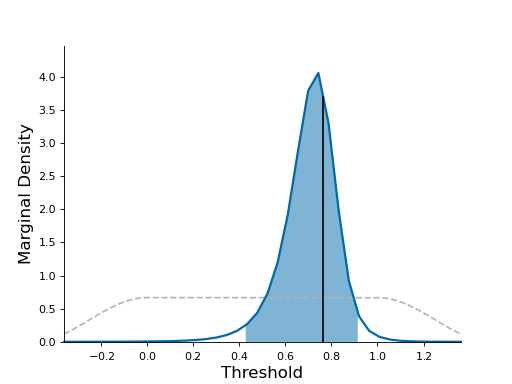

In [28]:
param_names = ['threshold', 'width', 'lambda', 'gamma', 'eta']
n_params = len(param_names)

pi = 0
par = param_names[pi]
fig, ax = pl.subplots()

ax=ps.psigniplot.plotMarginal(res_, dim=pi, axisHandle=ax)


<IPython.core.display.Javascript object>


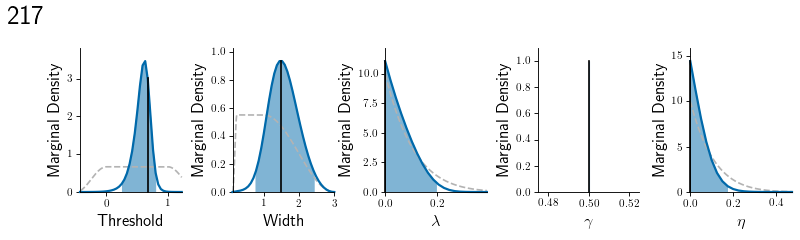

Error: The parameter you wanted to plot was fixed in the analysis!


/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/psignifit/psigniplot.py:324: UserWarning: Attempting to set identical left == right == 0.5 results in singular transformations; automatically expanding.
  plt.xlim([min(x), max(x)])


Text(0.01, 0.9, '217')

In [34]:
param_names = ['threshold', 'width', 'lambda', 'gamma', 'eta']
n_params = len(param_names)
fig, axn = pl.subplots(1, n_params, figsize=(10,3))

for pi, par in enumerate(param_names):
    ax=axn[pi]
    ax=ps.psigniplot.plotMarginal(res_, dim=pi, axisHandle=ax)
pl.subplots_adjust(left=0.1, right=0.99, bottom=0.2, wspace=0.5, top=0.8)

fig.text(0.01, 0.9, rid, fontsize=24)

# figname = 'marginals_%s' % animalid
# pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
# print(curr_dst_dir, figname)

<IPython.core.display.Javascript object>


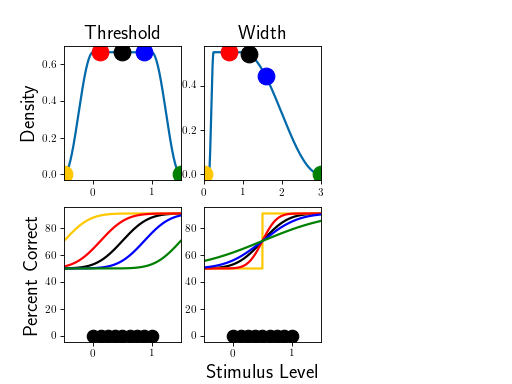

/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/psignifit/psigniplot.py:443: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2,3,4)
/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/psignifit/psigniplot.py:445: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2,3,1)
/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/psignifit/psigniplot.py:443: Ma

In [250]:
fig, ax = pl.subplots()
ps.psigniplot.plotPrior(res) #,axisHandle=ax)

# Goodness of fit

In [35]:
def getDeviance(result,Nsamples=None):
    fit = result['Fit']
    data = result['data']
    pPred = fit[3] + (1-fit[2]-fit[3]) * result['options']['sigmoidHandle'](data[:,0], fit[0], fit[1])
    
    pMeasured = data[:,1]/data[:,2]
    loglikelihoodPred = data[:,1]*np.log(pPred)+(data[:,2]-data[:,1])*np.log((1-pPred))
    loglikelihoodMeasured = data[:,1]*np.log(pMeasured)+(data[:,2]-data[:,1])*np.log((1-pMeasured))
    loglikelihoodMeasured[pMeasured==1] = 0;
    loglikelihoodMeasured[pMeasured==0] = 0;

    #devianceResiduals = -2*np.sign(pMeasured-pPred)*(loglikelihoodMeasured - loglikelihoodPred)
    #deviance = np.sum(np.abs(devianceResiduals))
    devianceResiduals = np.sign(pMeasured-pPred)*np.sqrt(2*(loglikelihoodMeasured - loglikelihoodPred))
    deviance = np.sum(devianceResiduals**2)
    
    if Nsamples is None:
        return devianceResiduals,deviance
    else: 
        r_vals=[]
        samples_devianceResiduals = np.zeros((Nsamples,data.shape[0]))
        for iData in range(data.shape[0]):
            samp_dat = np.random.binomial(data[iData,2],pPred[iData],Nsamples)
            #print(samp_dat)
            pMeasured = samp_dat/data[iData,2]
            #print(pMeasured)
            loglikelihoodPred = samp_dat*np.log(pPred[iData])+(data[iData,2]-samp_dat)*np.log(1-pPred[iData])
            loglikelihoodMeasured = samp_dat*np.log(pMeasured)+(data[iData,2]-samp_dat)*np.log(1-pMeasured)
            loglikelihoodMeasured[pMeasured==1] = 0
            loglikelihoodMeasured[pMeasured==0] = 0
            #samples_devianceResiduals[:,iData] = -2*np.sign(pMeasured-pPred[iData])*(loglikelihoodMeasured - loglikelihoodPred)
            samples_devianceResiduals[:,iData] = np.sign(pMeasured-pPred[iData])*np.sqrt(2.*(loglikelihoodMeasured - loglikelihoodPred))
        r_vals=[]
        for iS in range(Nsamples):
            sr = samples_devianceResiduals[iS, :]
            r, p = spstats.pearsonr(pPred, sr)
            r_vals.append(r)
            
        #samples_deviance = np.sum(np.abs(samples_devianceResiduals),axis=1)
        samples_deviance = np.sum(samples_devianceResiduals**2,axis=1)
        return devianceResiduals,deviance,samples_devianceResiduals,samples_deviance, r_vals

def get_empirical_ci(stat, ci=0.95):
    p = ((1.0-ci)/2.0) * 100
    lower = np.percentile(stat, p) #max(0.0, np.percentile(stat, p))
    p = (ci+((1.0-ci)/2.0)) * 100
    upper = np.percentile(stat, p) # min(1.0, np.percentile(x0, p))
    #print('%.1f confidence interval %.2f and %.2f' % (alpha*100, lower, upper))
    return lower, upper

In [36]:
d_resid, d, samples_d_resid, samples_d, r_vals = getDeviance(res_, Nsamples=5000)
d_resid.shape, d.shape, samples_d_resid.shape, samples_d.shape
assert d == np.sum(d_resid**2)
print(d)

/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in log
/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in multiply


3.878576649067748


In [38]:
fit = res_['Fit']
data = res_['data']
pPred = fit[3] + (1-fit[2]-fit[3]) * res_['options']['sigmoidHandle'](data[:,0], fit[0], fit[1])
data_r, data_p = spstats.pearsonr(pPred, d_resid)
ci_lo, ci_hi = get_empirical_ci(r_vals)

In [40]:
col='gray'
fig,axn=pl.subplots(1,3, figsize=(8,3))
ax=axn[0]
sns.histplot(data=samples_d, ax=ax, color=col)
ax.axvline(x=d, color='r')
ax.set_xlabel('deviance')
ci_lo_sampled, ci_hi_sampled = get_empirical_ci(samples_d)
for ci in [ci_lo_sampled, ci_hi_sampled]:
    ax.axvline(x=ci, color=col, linestyle=':')
ax.text(ci_lo_sampled-2, -30, round(ci_lo_sampled, 2), color='r')
ax.set_title('D=%.2f' % d, loc='left')

ax=axn[1]
ax.scatter(pPred, d_resid, label='r=%.2f' % data_r, c=col)
ax.legend()
ax.set_xlabel('prediction')
ax.set_ylabel('deviance residuals')
ax.axhline(y=0.5, color='gray')

ax=axn[2]
sns.histplot(data=r_vals, ax=ax, color=col)
ax.axvline(x=data_r, color='r')
for ci in [ci_lo, ci_hi]:
    ax.axvline(x=ci, color=col, linestyle=':')
ax.set_xlabel('model prediction, r')

pl.subplots_adjust(left=0.1, right=0.95, bottom=0.2, wspace=0.5, top=0.8)

fig.text(0.01, 0.9, rid, fontsize=24)

figname = 'deviance_%s' % animalid
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)


<IPython.core.display.Javascript object>

NameError: name 'animalid' is not defined

In [283]:
min(r_vals)

-0.9417343157475857